In [34]:
# -*- coding: utf-8 -*-
"""
Copyright 2018 Alexey Melnikov and Katja Ried.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License.
Please acknowledge the authors when re-using this code and maintain this notice intact.
Code written by Katja Ried
"""

import __future__
import numpy as np
import os# for current directory
import sys # include paths to subfolders for agents and environments
sys.path.insert(0, 'agents')
sys.path.insert(0, 'environments')

"""Import and initialise an environment and an agent.
Different environments or agent types require different arguments, 
as specified in the docstring/help inside the respective files."""

#environment
import env_quantum_circuit_synthesis
env = env_quantum_circuit_synthesis.TaskEnvironment(env_config)

#agent
import ps_agent_basic
#parameters for the agent - explanations can be found in the comments inside the agent file
gamma_damping, eta_glow_damping, policy_type, beta_softmax, num_reflections =  0, 0.1, 'softmax', 1, 0
agent = ps_agent_basic.BasicPSAgent(env.num_actions, env.num_percepts_list, gamma_damping, eta_glow_damping, policy_type, beta_softmax, num_reflections)

In [35]:
"""Initialise and run interaction"""
#set number of trials and maximum number of steps in each trial
num_trials = 100
max_steps_per_trial = 100 #This doesn't actually matter for invasion_game, which ends every trial after a single step

#initialise a record of performance
learning_curve = np.zeros(num_trials)
step_curve = np.zeros(num_trials)
reward = 0 #temporarily stores the reward for the most recent action
for i_trial in range(num_trials):
    reward_trial = 0 #additive counter of the total rewards earned during the current trial
    discretized_observation = env.reset()
    for t in range(max_steps_per_trial):
        #This is where the heart of the interaction takes place
        action = agent.deliberate_and_learn(discretized_observation, reward)
        discretized_observation, reward, done = env.move(action)
        reward_trial += reward
        if done:
            break
    learning_curve[i_trial] = float(reward_trial)/(t+1)
    step_curve[i_trial] = (t+1)


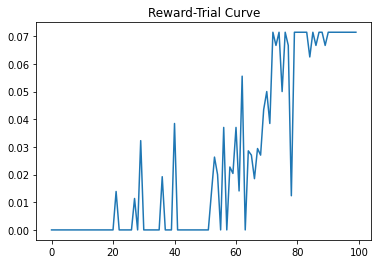

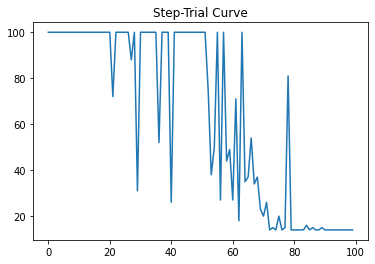

In [36]:
"""Return results"""
import matplotlib.pyplot as plt
plt.title("Reward-Trial Curve")
plt.plot(learning_curve)
plt.show()
plt.title("Step-Trial Curve")
plt.plot(step_curve)
plt.show()